In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

#import lsst.ip.diffim as ipDiffim
# I linked from ip_diffim/python/lsst/ip/diffim/imageMapReduce.py into diffimTests/imageMapReduce.py
#    (or copy it)

In [2]:
import diffimTests as dit
#reload(dit)

testObj = dit.DiffimTest(varFlux2=np.repeat(620*np.sqrt(2), 10),
                         n_sources=600, verbose=True, sourceFluxRange=(2000., 120000.), 
                         psf_yvary_factor=0.5, psfSize=13)
res = testObj.runTest(spatialKernelOrder=2)
print res

Template PSF: [1.6, 1.6] 0.0
Science PSF: [1.8, 2.2] -45.0
0.824621125124
Offset: [0.0, 0.0]
PSF y spatial-variation: -0.492813481453 0.493450410102
Variable source: 9 368.142255845 52.2977464926 0 876.812408671
Variable source: 3 437.677528631 394.051374239 0 876.812408671
Variable source: 7 77.2355874401 392.237254371 0 876.812408671
Variable source: 4 466.336488467 328.755746086 0 876.812408671
Variable source: 10 66.5809759253 363.20308398 0 876.812408671
Variable source: 6 352.24315562 433.633351478 0 876.812408671
Variable source: 1 237.897633976 429.430670374 0 876.812408671
Variable source: 2 260.515557753 389.705213876 0 876.812408671
Variable source: 8 184.879430277 305.582257912 0 876.812408671
Variable source: 0 300.731568916 220.088731954 0 876.812408671
{'Zogy': {'FP': 32, 'FN': 6, 'TP': 4}, 'ALstack': {'FP': 8, 'FN': 3, 'TP': 7}, 'SZogy': {'FP': 27, 'FN': 4, 'TP': 6}, 'ALstack_decorr': {'FP': 2, 'FN': 5, 'TP': 5}}


In [3]:
exposure = testObj.im2.asAfwExposure()
template = testObj.im1.asAfwExposure()

A&L(dec): stats(mean=0.073735416, stdev=24.737297, min=-211.36177, max=231.1548)
Zogy: stats(mean=-0.063233111527110475, stdev=24.951115647110598, min=-926.54759686176419, max=962.03978488682367)
A&L(dec) - Zogy: stats(mean=-0.01134573746696277, stdev=2.6089159538719775, min=-848.58489749668695, max=920.58648554689853)
A&L(dec) - A&L: stats(mean=-0.025930362, stdev=6.9146481, min=-60.443314, max=62.172623)
Scorr: stats(mean=2.7517494985560403e-06, stdev=0.00026777295941810643, min=-0.017526331599275958, max=0.013023830802469319)
Scorr_var: stats(mean=0.0002519801078529365, stdev=1.4351225669407179e-06, min=0.00024662692267643982, max=0.00085157295222638139)


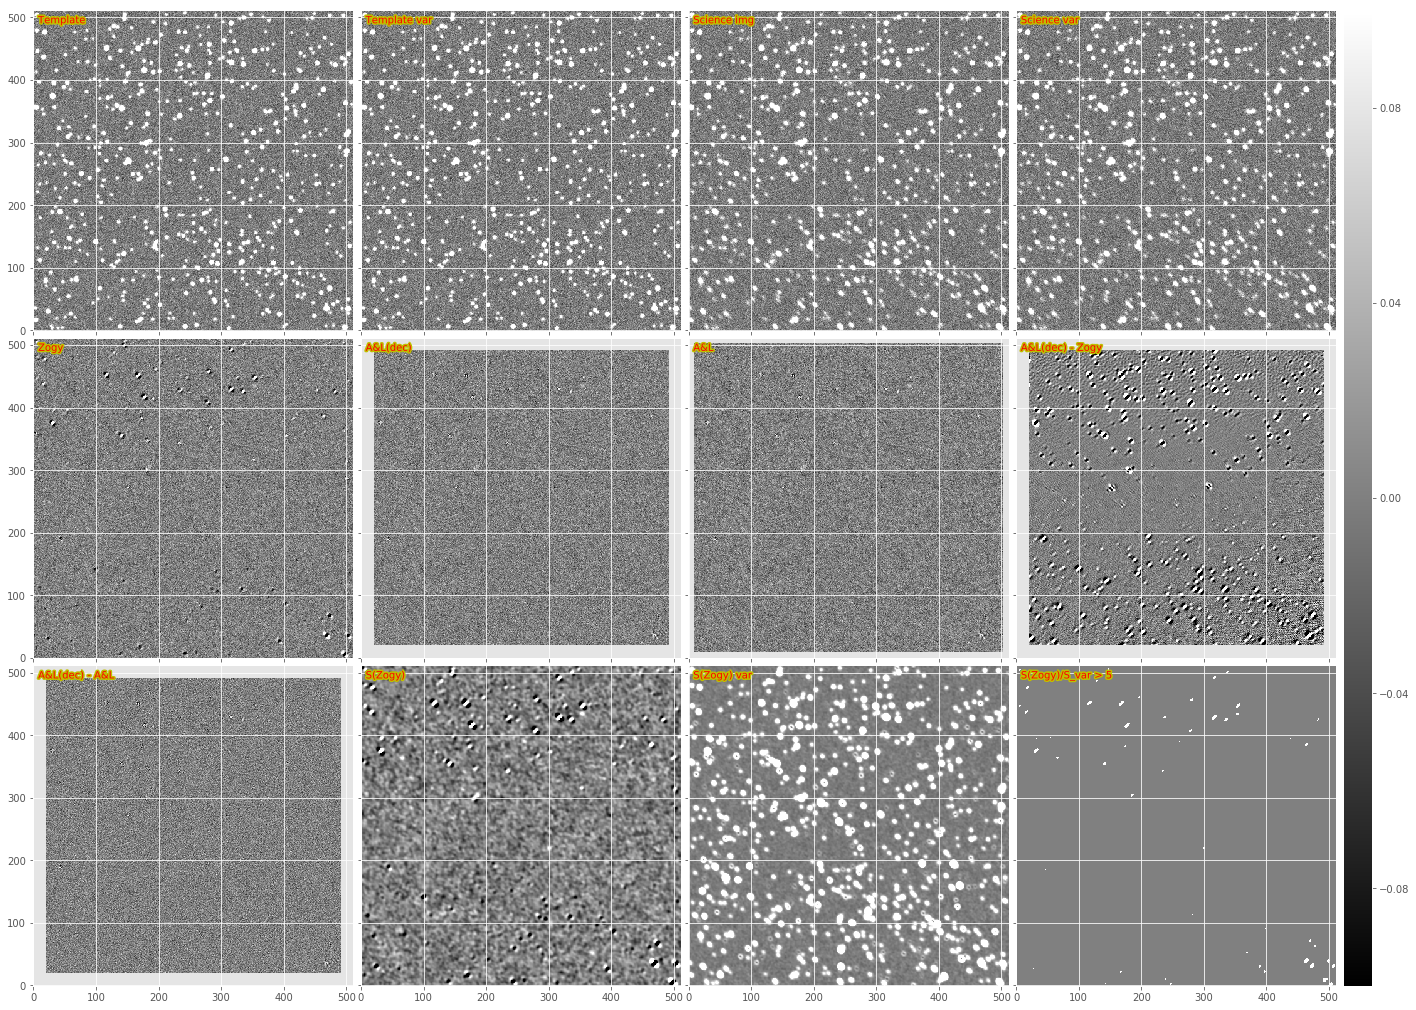

In [4]:
#dit.plotImageGrid((testObj.im1.im, testObj.im2.im), imScale=8)
testObj.doPlot(imScale=6, include_Szogy=True);

In [5]:
dit.plotImageGrid((testObj.variablePsf.getImage(20., 20.), 
                   testObj.variablePsf.getImage(250., 250.),
                   testObj.variablePsf.getImage(500., 500.)))

OK, let's try a spatially-varying A&L Decorrelation!

But without correctly setting the (spatially varying) PSF of the diffim.

In [22]:
import lsst.pex.config as pexConfig
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.pipe.base as pipeBase
import lsst.ip.diffim as ipDiffim

class ALdecMapperSubtask(dit.ImageMapperSubtask):
    ConfigClass = dit.ImageMapperSubtaskConfig
    _DefaultName = 'diffimTests_ALdecMapperSubtask'
    
    def __init__(self, *args, **kwargs):
        dit.ImageMapperSubtask.__init__(self, *args, **kwargs)
        
    def run(self, subExp, expandedSubExp, fullBBox, **kwargs):
        bbox = subExp.getBBox()
        center = ((bbox.getBeginX() + bbox.getEndX()) // 2., (bbox.getBeginY() + bbox.getEndY()) // 2.)
        center = afwGeom.Point2D(center[0], center[1])
        
        variablePsf2 = kwargs.get('variablePsf', None)
        sigmaSquared = kwargs.get('sigmaSquared', None)
        alTaskResult = kwargs.get('alTaskResult', None)
        im1 = kwargs.get('template', None)  # im1 = input template
        im2 = kwargs.get('science', None)   # im2 = input science image
        preConvKernel = kwargs.get('preConvKernel', None)
                
        # subExp and expandedSubExp are subimages of the (decorrelated) diffim!
        
        subExp2 = afwImage.ExposureF(im2, expandedSubExp.getBBox())
        subim2 = expandedSubExp.getMaskedImage()
        if sigmaSquared is None:
            subvar2 = subim2.getVariance().getArray()
            sig2squared = dit.computeClippedImageStats(subvar2).mean
        else:
            sig2squared = sigmaSquared[1]  # for testing, can use the input sigma (global value for entire exposure)
        
        # Psf and image for template img (index 1)
        subExp1 = afwImage.ExposureF(im1, expandedSubExp.getBBox())
        subim1 = subExp1.getMaskedImage()
        if sigmaSquared is None:
            subvar1 = subim1.getVariance().getArray()
            sig1squared = dit.computeClippedImageStats(subvar1).mean
        else:
            sig1squared = sigmaSquared[0]

        # This code taken more-or-less directly from dit.tasks.doALdecorrelation:
        kimg = dit.afw.alPsfMatchingKernelToArray(alTaskResult.psfMatchingKernel, coord=center)
        dck = dit.decorrelation.computeDecorrelationKernel(kimg, sig1squared, sig2squared,
                                                     preConvKernel=preConvKernel, delta=0.)
        diffim, _ = dit.afw.doConvolve(expandedSubExp, dck, use_scipy=False)
        img = diffim.getMaskedImage().getImage().getArray()
        img[~np.isfinite(img)] = np.nan
        img = diffim.getMaskedImage().getVariance().getArray()
        img[~np.isfinite(img)] = np.nan
        psf = dit.afw.afwPsfToArray(alTaskResult.subtractedExposure.getPsf(), coord=center)
        # NOTE! Need to compute the updated PSF including preConvKernel !!! This doesn't do it:
        psfc = dit.decorrelation.computeCorrectedDiffimPsf(kimg, psf, tvar=sig1squared, svar=sig2squared)
        psfcI = afwImage.ImageD(psfc.shape[0], psfc.shape[1])
        psfcI.getArray()[:, :] = psfc
        psfcK = afwMath.FixedKernel(psfcI)
        psfNew = measAlg.KernelPsf(psfcK)
        diffim.setPsf(psfNew)
        out = afwImage.ExposureF(diffim, subExp.getBBox())
                
        return pipeBase.Struct(subExposure=out, decorrelationKernel=dck, psf=psfNew)

class ALdecMapReduceConfig(dit.ImageMapReduceConfig):
    mapperSubtask = pexConfig.ConfigurableField(
        doc='A&L decorrelation subtask to run on each sub-image',
        target=ALdecMapperSubtask
    )

In [7]:
config = ALdecMapReduceConfig()
#config.gridStepX = config.gridStepY = 5
#config.gridSizeX = config.gridSizeY = 7
config.borderSizeX = config.borderSizeY = 3
config.reducerSubtask.reduceOperation = 'average'
task = dit.ImageMapReduceTask(config=config)
print config
#boxes0, boxes1 = task._generateGrid(exposure)

{'gridStepY': 10.0, 'gridStepX': 10.0, 'mapperSubtask': {}, 'gridSizeX': 10.0, 'gridSizeY': 10.0, 'gridCentroidsY': None, 'gridCentroidsX': None, 'reducerSubtask': {'reduceOperation': 'average'}, 'adjustGridOption': 'spacing', 'borderSizeX': 3.0, 'borderSizeY': 3.0, 'scaleByFwhm': True, 'ignoreMaskPlanes': ['INTRP', 'EDGE', 'DETECTED', 'SAT', 'CR', 'BAD', 'NO_DATA', 'DETECTED_NEGATIVE']}


In [8]:
diffimOrig = testObj.ALres.subtractedExposure
newExp = task.run(diffimOrig, template=template, science=exposure,
                 alTaskResult=testObj.ALres, forceEvenSized=True).exposure #, variablePsf=testObj.variablePsf)

diffimTests/imageMapReduce.py:268: RuntimeWarning: invalid value encountered in true_divide
  newMI.getImage().getArray()[:, :] /= wts
diffimTests/imageMapReduce.py:269: RuntimeWarning: invalid value encountered in true_divide
  newMI.getVariance().getArray()[:, :] /= wts


In [9]:
# Run with constant variance number to compare with single frame (non-gridded) ZOGY from above:
sig1 = dit.computeClippedImageStats(template.getMaskedImage().getVariance().getArray()).mean
sig2 = dit.computeClippedImageStats(exposure.getMaskedImage().getVariance().getArray()).mean
print sig1, sig2
newExpA = task.run(diffimOrig, template=template, science=exposure,
                 alTaskResult=testObj.ALres, sigmaSquared=[sig1, sig2], forceEvenSized=True).exposure

301.744 302.974


In [10]:
def ga(exposure):
    return exposure.getMaskedImage().getImage().getArray()
def gv(exposure):
    return exposure.getMaskedImage().getVariance().getArray()

stats(mean=2.9742591, stdev=19.082579, min=-74.0, max=4435.0)
stats(mean=0.072448753, stdev=24.179245, min=-201.01538, max=223.78836)
stats(mean=0.070600323, stdev=24.527882, min=-205.06778, max=227.48572)
stats(mean=-0.025369771, stdev=6.3646493, min=-53.972443, max=54.806183)
stats(mean=0.0032858462, stdev=0.6654712, min=-9.0453033, max=10.34639)
stats(mean=-0.027648015, stdev=6.7217283, min=-57.321259, max=58.50354)
stats(mean=0.00036328938, stdev=0.43233219, min=-7.2582855, max=6.2939911)


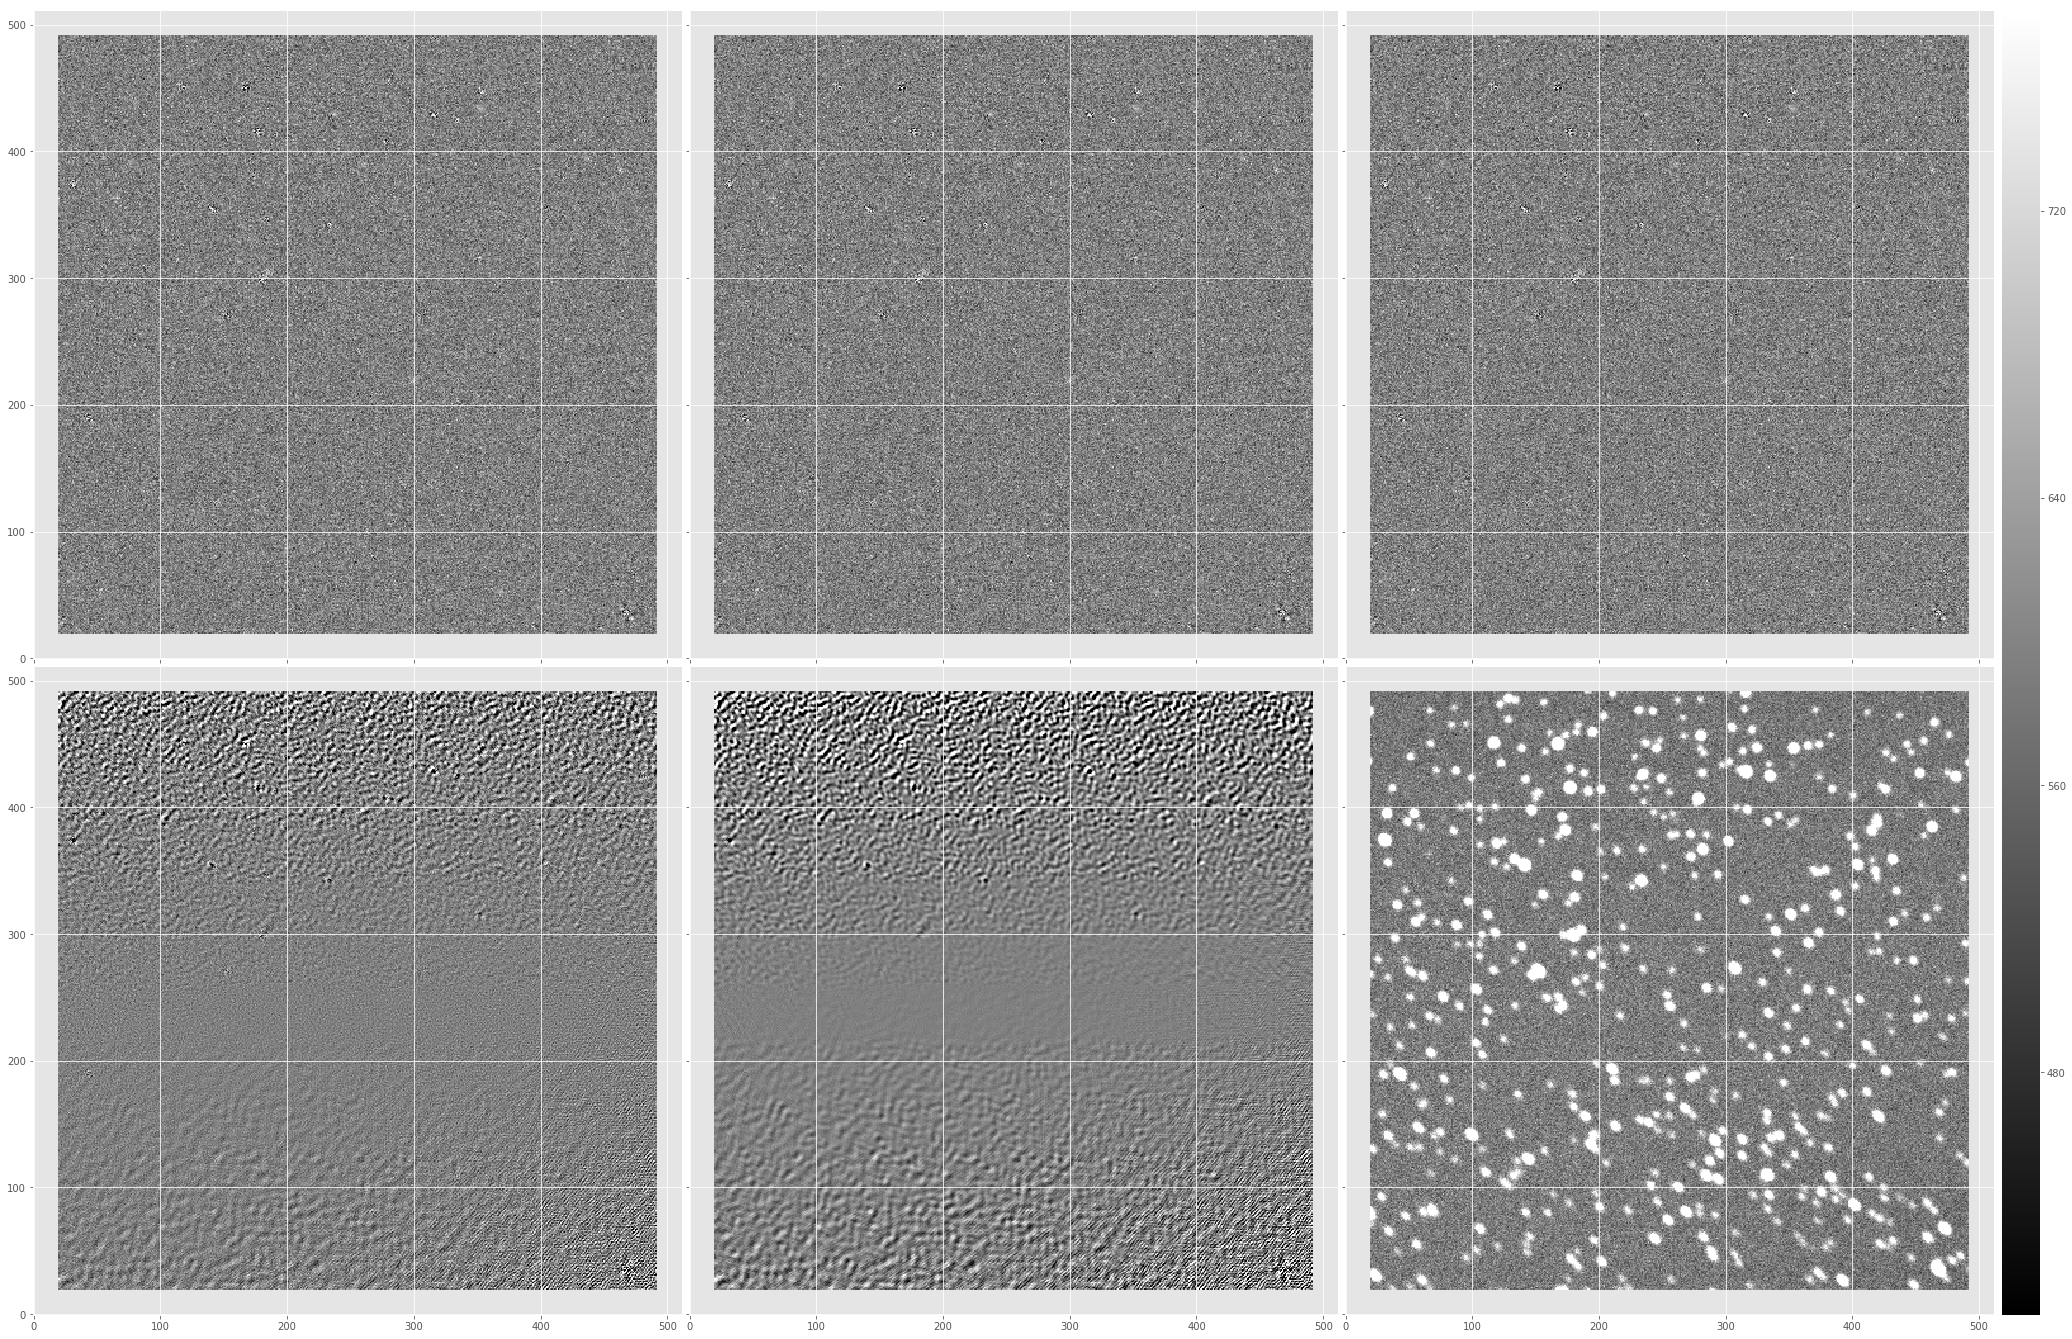

In [14]:
print dit.computeClippedImageStats(ga(exposure))
print dit.computeClippedImageStats(ga(newExp))
print dit.computeClippedImageStats(ga(newExpA))
print dit.computeClippedImageStats(ga(newExp)-ga(testObj.ALres.subtractedExposure))
print dit.computeClippedImageStats(ga(newExp)-ga(testObj.ALres.decorrelatedDiffim))
print dit.computeClippedImageStats(ga(newExpA)-ga(testObj.ALres.subtractedExposure))
print dit.computeClippedImageStats(ga(newExpA)-ga(testObj.ALres.decorrelatedDiffim))
dit.plotImageGrid((ga(newExp), ga(newExpA), ga(testObj.ALres.decorrelatedDiffim), 
                   ga(newExp)-ga(testObj.ALres.decorrelatedDiffim),
                   ga(newExpA)-ga(testObj.ALres.decorrelatedDiffim), gv(newExp)), imScale=12)

In [12]:
print task.config
task._plotBoxes(exposure.getBBox(), skip=5)

{'gridStepY': 10.0, 'gridStepX': 10.0, 'mapperSubtask': {}, 'gridSizeX': 10.0, 'gridSizeY': 10.0, 'gridCentroidsY': None, 'gridCentroidsX': None, 'reducerSubtask': {'reduceOperation': 'average'}, 'adjustGridOption': 'spacing', 'borderSizeX': 3.0, 'borderSizeY': 3.0, 'scaleByFwhm': True, 'ignoreMaskPlanes': ['INTRP', 'EDGE', 'DETECTED', 'SAT', 'CR', 'BAD', 'NO_DATA', 'DETECTED_NEGATIVE']}


Let's take a look at the decorrelation kernels and PSFs used on the various patches...

In [29]:
config = ALdecMapReduceConfig()
#config.gridStepX = config.gridStepY = 5
#config.gridSizeX = config.gridSizeY = 7
config.borderSizeX = config.borderSizeY = 3
config.reducerSubtask.reduceOperation = 'average'
task = dit.ImageMapReduceTask(config=config)
print config
#boxes0, boxes1 = task._generateGrid(exposure)

results = task._runMapper(diffimOrig, template=template, science=exposure,
                 alTaskResult=testObj.ALres, forceEvenSized=True)

{'gridStepY': 10.0, 'gridStepX': 10.0, 'mapperSubtask': {}, 'gridSizeX': 10.0, 'gridSizeY': 10.0, 'gridCentroidsY': None, 'gridCentroidsX': None, 'reducerSubtask': {'reduceOperation': 'average'}, 'adjustGridOption': 'spacing', 'borderSizeX': 3.0, 'borderSizeY': 3.0, 'scaleByFwhm': True, 'ignoreMaskPlanes': ['INTRP', 'EDGE', 'DETECTED', 'SAT', 'CR', 'BAD', 'NO_DATA', 'DETECTED_NEGATIVE']}


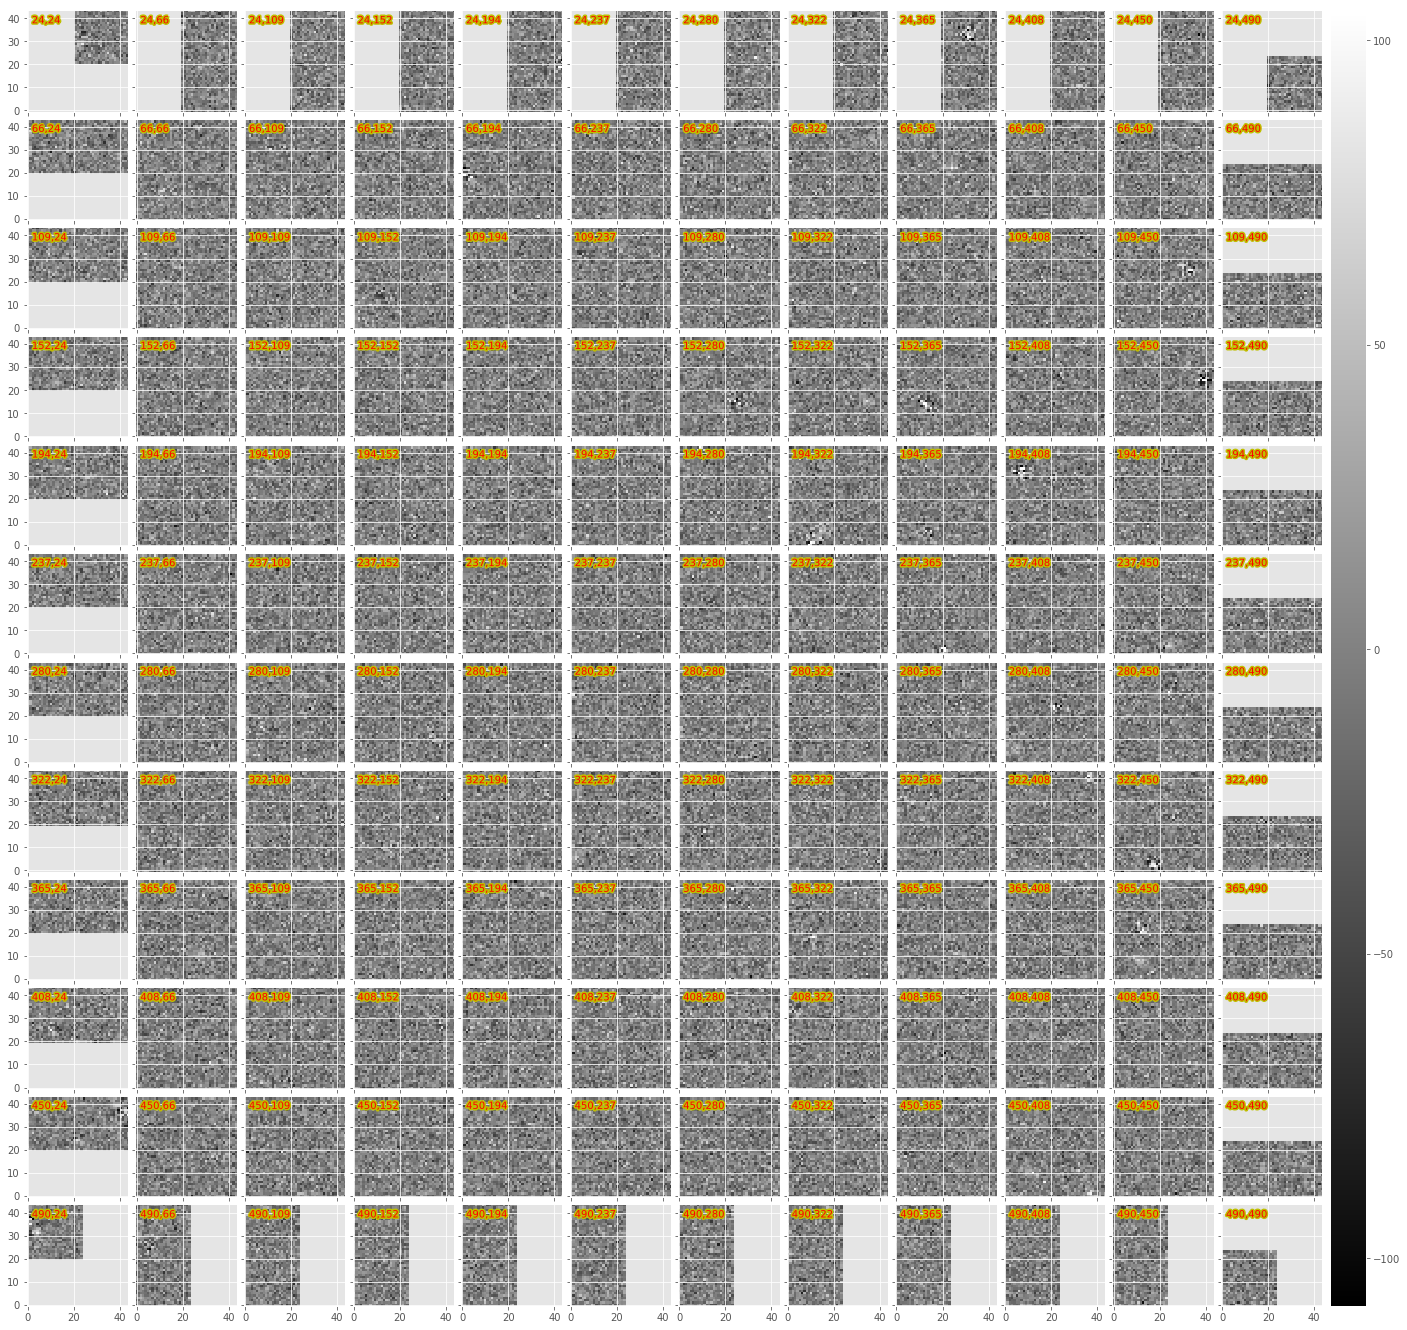

In [32]:
def getCenter(bbox):
    return ((bbox.getBeginX() + bbox.getEndX()) // 2., (bbox.getBeginY() + bbox.getEndY()) // 2.)

centers = [getCenter(res.subExposure.getBBox()) for res in results]
titles = ['%.0f,%.0f'%(c[0],c[1]) for c in centers]
subs = [res.subExposure for res in results]
dit.plotImageGrid(subs, titles=titles) #, clim=(-0.001,0.001))

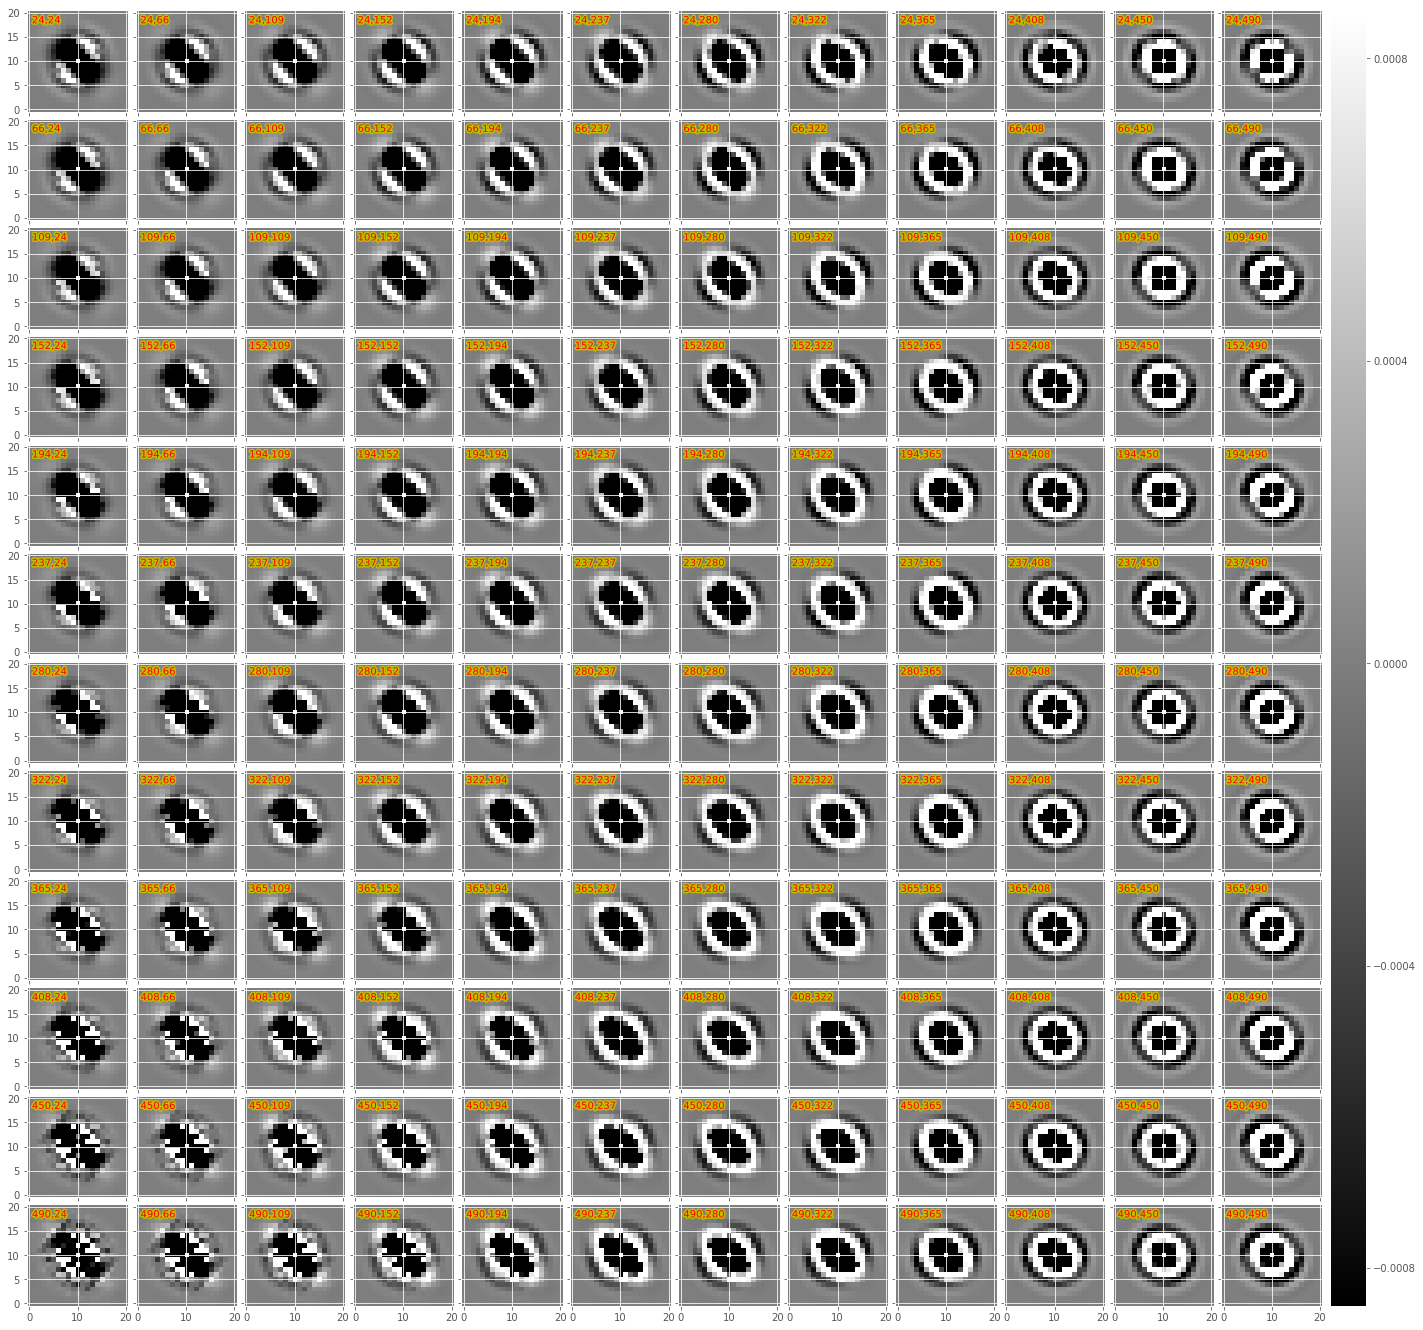

In [33]:
dcks = [res.decorrelationKernel for res in results]
dit.plotImageGrid(dcks, titles=titles)

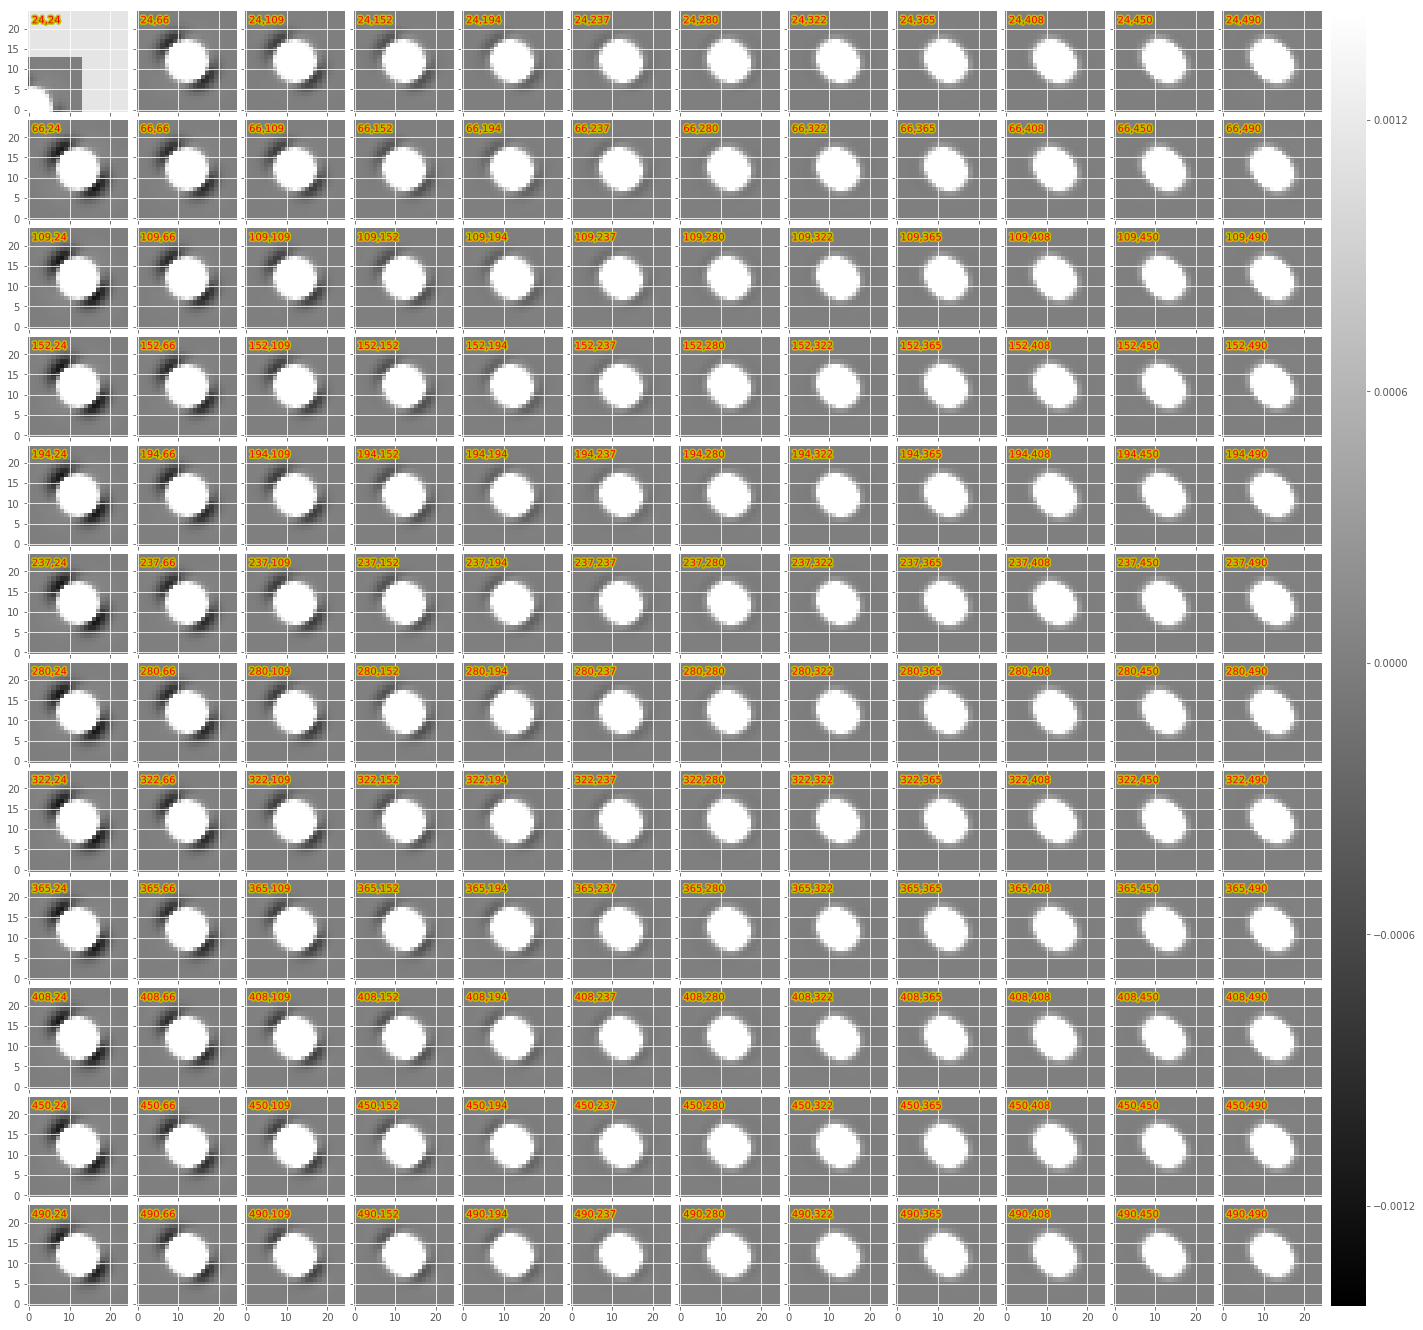

In [35]:
psfs = [res.psf for res in results]
dit.plotImageGrid(psfs, titles=titles)

In [14]:
testObj.runTest(spatialKernelOrder=2)

{'ALstack': {'FN': 3, 'FP': 8, 'TP': 7},
 'ALstack_decorr': {'FN': 5, 'FP': 2, 'TP': 5},
 'SZogy': {'FN': 4, 'FP': 27, 'TP': 6},
 'Zogy': {'FN': 6, 'FP': 32, 'TP': 4}}

In [15]:
testObj2 = testObj.clone()
testObj2.ALres.decorrelatedDiffim = newExp
testObj2.runTest()

{'ALstack': {'FN': 3, 'FP': 8, 'TP': 7},
 'ALstack_decorr': {'FN': 5, 'FP': 2, 'TP': 5},
 'SZogy': {'FN': 4, 'FP': 27, 'TP': 6},
 'Zogy': {'FN': 6, 'FP': 32, 'TP': 4}}

In [16]:
testObj2 = testObj.clone()
testObj2.ALres.decorrelatedDiffim = newExpA
testObj2.runTest()

{'ALstack': {'FN': 3, 'FP': 8, 'TP': 7},
 'ALstack_decorr': {'FN': 6, 'FP': 2, 'TP': 4},
 'SZogy': {'FN': 4, 'FP': 27, 'TP': 6},
 'Zogy': {'FN': 6, 'FP': 32, 'TP': 4}}

Let's try making a CoaddPsf, following the example in `meas_algorithms/tests/testCoaddPsf.py`

In [41]:
import lsst.afw.table as afwTable
import lsst.afw.coord as afwCoord

schema = afwTable.ExposureTable.makeMinimalSchema()
schema.addField("customweightname", type="D", doc="Coadd weight")
mycatalog = afwTable.ExposureCatalog(schema)

cd11 = 5.55555555e-05
cd12 = cd21 = 0.0
cd22 = 5.55555555e-05
crval1 = crval2 = 0.0
crpix = afwGeom.PointD(1000, 1000)
crval = afwCoord.Coord(afwGeom.Point2D(crval1, crval2))
wcsref = afwImage.makeWcs(crval, crpix, cd11, cd12, cd21, cd22)

# Each of the 9 has its peculiar Psf, Wcs, weight, and bounding box.
for i in range(1, 10, 1):
    record = mycatalog.getTable().makeRecord()
    psf = measAlg.DoubleGaussianPsf(100, 100, i, 1.00, 0.0)
    record.setPsf(psf)
    crpix = afwGeom.PointD(i*1000.0, i*1000.0)
    wcs = afwImage.makeWcs(crval, crpix, cd11, cd12, cd21, cd22)

    record.setWcs(wcs)
    record['customweightname'] = 1.0 * (i+1)
    record['id'] = i
    bbox = afwGeom.Box2I(afwGeom.Point2I(0, 0), afwGeom.Extent2I(i*1000, i*1000))
    record.setBBox(bbox)
    mycatalog.append(record)

# create the coaddpsf
mypsf = measAlg.CoaddPsf(mycatalog, wcsref, 'customweightname')

Now try it on our stuff...

In [50]:
import lsst.afw.table as afwTable
import lsst.afw.coord as afwCoord

schema = afwTable.ExposureTable.makeMinimalSchema()
schema.addField("weight", type="D", doc="Coadd weight")
mycatalog = afwTable.ExposureCatalog(schema)

wcsref = exposure.getWcs()

subs = [res.subExposure for res in results]
bboxes = [res.subExposure.getBBox() for res in results]
centers = [getCenter(res.subExposure.getBBox()) for res in results]
psfs = [res.psf for res in results]

# Each of the 9 has its peculiar Psf, Wcs, weight, and bounding box.
for psf, bbox, center, subExp in zip(psfs, bboxes, centers, subs):
    record = mycatalog.getTable().makeRecord()
    record.setPsf(psf)
    wcs = subExp.getWcs().clone()

    record.setWcs(wcs)
    record['weight'] = 1.0
    record['id'] = i
    record.setBBox(bbox)
    mycatalog.append(record)

# create the coaddpsf
mypsf = measAlg.CoaddPsf(mycatalog, wcsref, 'weight')

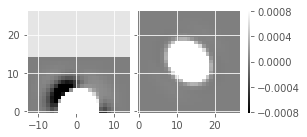

In [52]:
dit.plotImageGrid((mypsf.computeKernelImage(afwGeom.Point2D(20,20)),
                   mypsf.computeKernelImage(afwGeom.Point2D(480,480)),))

In [51]:
?mypsf.computeKernelImage